# Covid X-Ray Diagnosis
## Machine Learning Final Project
### Enver Kapetanovic & Adrien Ventugol 
### Group 15

In [1]:
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import pandas as pd 
import numpy as np
import sklearn
import imblearn

In [2]:
#First import the paths of the pictures that we created with DataProcessor.ipynb
paths = None
paths = pd.read_csv("paths.csv")

In [3]:
#initiate the list we will use to first store the pixel data, then pass into the dataframe.
pixel_data = []

In [4]:
#define a processing function to obtain transformed pixel data from the paths of the images
def to_pixel(row):
    color_img = Image.open(row["image_path"])
    resized = color_img.resize((50, 50), Image.NEAREST) #Nearest resample give the best results
    sharpened = ImageEnhance.Sharpness(resized).enhance(2.0)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    pixel_data.append(np.asarray(gray_img).flatten().tolist()) #convert image to numpy array, flatten it, convert to list
    color_img.close()
    # pixel data now has the complete data of another picture at pixel_data[-1]

In [5]:
#apply use the functions as lambdas to apply to all the rows
paths.apply(lambda row: to_pixel(row), axis = 1)

#Separate Data into X and y
y = paths.loc[0:,'Test']
X = pd.DataFrame(data = pixel_data)

In [6]:
#check X
X

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,42,40,173,38,38,36,36,35,207,220,...,178,183,179,180,186,188,180,173,163,150
1,54,63,60,73,51,76,113,89,80,122,...,73,149,127,153,157,134,134,112,114,72
2,0,255,4,4,4,4,3,3,3,3,...,129,122,140,96,58,35,18,0,1,2
3,255,0,0,0,0,0,0,0,0,0,...,146,117,46,9,0,0,0,0,0,0
4,0,255,0,0,0,0,0,0,0,0,...,169,147,166,93,28,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759,4,0,0,0,0,0,0,0,0,0,...,182,202,114,0,0,0,0,0,47,69
3760,0,0,0,0,0,0,0,0,0,0,...,237,235,205,218,199,197,203,185,156,159
3761,2,0,0,0,0,4,3,0,1,0,...,196,198,171,143,147,160,83,38,11,5
3762,17,0,0,0,0,0,0,106,0,1,...,210,225,178,164,70,0,0,0,0,0


In [7]:
#check y
y

0       1
1       1
2       1
3       1
4       1
       ..
3759    0
3760    0
3761    0
3762    0
3763    0
Name: Test, Length: 3764, dtype: int64

Text(0.5, 1.0, 'Average Pixel Distribution')

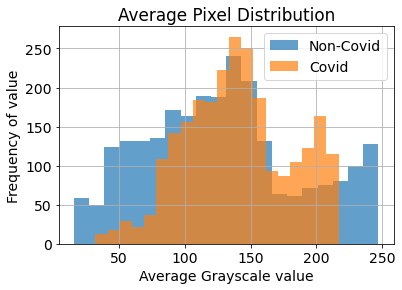

In [8]:
#Let's check the difference in pixel distribution after processing
X.loc[paths["Test"] == 0, :].mean().transpose().hist(bins = 20, alpha=0.7, label='Non-Covid')
X.loc[paths["Test"] == 1, :].mean().transpose().hist(bins = 20, alpha=0.7, label='Covid')
plt.xlabel("Average Grayscale value")
plt.ylabel("Frequency of value")
plt.legend(loc='upper right')
plt.title("Average Pixel Distribution")

In [9]:
#Train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, train_size=.8, random_state=0)

In [10]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#Normalize X using mean normalization. Minmax could partly negate the difference we've introduced earlier.
X_norm = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [12]:
#Imbalanced Data, Solve with Random Over Sampling Technique
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 3)

#In this current setup, oversampling reduces the number of False Negatives.
X_train,y_train = ros.fit_resample(X_norm,y_train)

In [13]:
#create dataframes to plot changes in distribution
normalized_X = pd.DataFrame(data = X_train)
normalized_y = pd.DataFrame(data = y_train)

Text(0.5, 1.0, 'Average Feature Distribution')

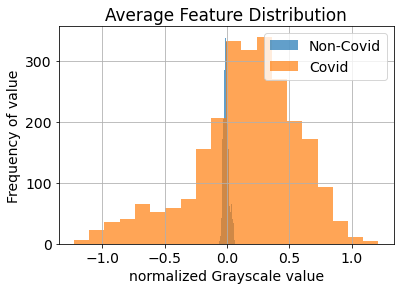

In [14]:
#Let's check the difference in feature distribution after normalization
normalized_X.loc[normalized_y["Test"] == 0, :].mean().transpose().hist(bins = 20, alpha=0.7, label='Non-Covid')
normalized_X.loc[normalized_y["Test"] == 1, :].mean().transpose().hist(bins = 20, alpha=0.7, label='Covid')

plt.xlabel("normalized Grayscale value")
plt.ylabel("Frequency of value")
plt.legend(loc='upper right')
plt.title("Average Feature Distribution")

Text(0.5, 1.0, 'Average Distribution of Features')

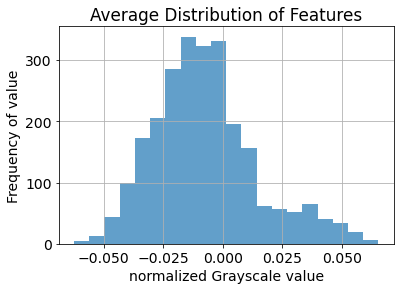

In [15]:
normalized_X.loc[normalized_y["Test"] == 0, :].mean().transpose().hist(bins = 20, alpha=0.7, label='Non-Covid')
plt.xlabel("normalized Grayscale value")
plt.ylabel("Frequency of value")
plt.title("Average Distribution of Features")

Text(0.5, 1.0, 'Average Distribution of Pixels')

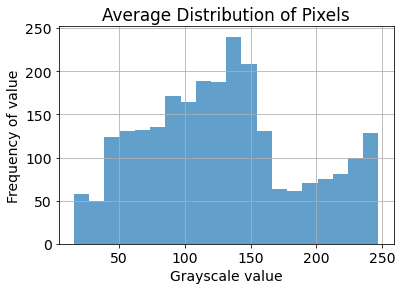

In [16]:
X.loc[paths["Test"] == 0, :].mean().transpose().hist(bins = 20, alpha=0.7, label='Non-Covid')
plt.xlabel("Grayscale value")
plt.ylabel("Frequency of value")
plt.title("Average Distribution of Pixels")

In [18]:
from sklearn.naive_bayes import BernoulliNB
import sklearn.metrics as sk_mtrx

#train the model
clf = BernoulliNB()
clf.fit(normalized_X, y_train)
y_score_test = clf.predict(X_test)

test set:
recall score:		[0.97632312 0.91428571]
balanced accuracy score: 0.9453044170314365
 confusion matrix:
[[701  17]
 [  3  32]]
f1 score: 		0.7619047619047618


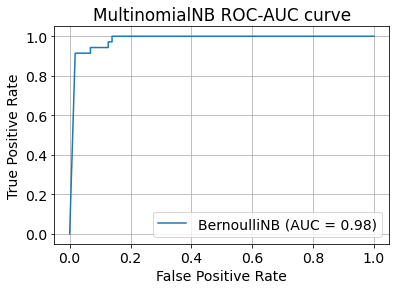

In [19]:

#metrics we are interested in
#for this model we are particularly interested in maximizing recall at the detriment of precision
recall = sk_mtrx.recall_score(y_test, y_score_test, average = None)
bal_acc = sk_mtrx.balanced_accuracy_score(y_test,y_score_test)
conf = sk_mtrx.confusion_matrix(y_test, y_score_test)
f1 = sk_mtrx.f1_score(y_test, y_score_test)


print("test set:")
print(("recall score:\t\t{0}\nbalanced accuracy score: {1}\n confusion matrix:\n{2}\n"+
"f1 score: \t\t{3}").format(recall, bal_acc, conf,f1))


sk_mtrx.plot_roc_curve(clf, X_test, y_test)
plt.title("MultinomialNB ROC-AUC curve")
plt.grid()

## Let's try our model on pictures!
### Feel free to load your own pictures on the last line

In [20]:
cov = "Demo\\covid-demo.jpg"
non = "Demo\\normal-demo.jpg"

In [21]:
def test_model(path):
    pic = Image.open(path)
    resized = pic.resize((50, 50), Image.NEAREST)
    sharpened = ImageEnhance.Sharpness(resized).enhance(2.0)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    covid_pixels = np.asarray(gray_img).flatten()
    
    pic.close()
    covid_pixels = pd.DataFrame(data = covid_pixels).transpose()
    covid_pixels = std_scaler.transform(covid_pixels)
    if clf.predict(covid_pixels)[0] == 1:
        print("The patient has covid.")
    else:
        print("The patient does not have covid.")

In [22]:
for pic in [cov,non]:
    test_model(pic)

The patient has covid.
The patient does not have covid.


In [ ]:
#Your turn!
#test_model(...)